In [4]:
# Standard library
import sys
from pathlib import Path

# Third-party
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Add src directory to path
sys.path.append(str(Path.cwd().parent))


In [5]:
# Training hyperparameters
latent_dims = [256]
epochs = 50
batch_size = 128
learning_rate = 0.001

# Create models directory
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Create logs directory for TensorBoard
logs_dir = Path('../logs')
logs_dir.mkdir(exist_ok=True)

# Set random seeds for reproducibility
np.random.seed(315)
tf.random.set_seed(315)

# Configure GPU
gpu_id = 0  # Which GPU to use (0-indexed). Set to None to use all available GPUs.
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        if gpu_id is not None:

            # Use specific GPU
            tf.config.set_visible_devices(gpus[gpu_id], 'GPU')
            tf.config.experimental.set_memory_growth(gpus[gpu_id], True)
            print(f'Using GPU {gpu_id}: {gpus[gpu_id].name}')

        else:

            # Use all GPUs with memory growth
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            print(f'Using {len(gpus)} GPU(s): {[gpu.name for gpu in gpus]}')

    except RuntimeError as e:
        print(e)

else:
    print('No GPU available, using CPU')

No GPU available, using CPU


In [6]:
# loading the data

df = np.load('../data/DENTAL_1.NPZ')
df

NpzFile '../data/DENTAL_1.NPZ' with keys: x_train, y_train, x_test, y_test

In [7]:
X_train = df['x_train']
X_test = df['x_test']
y_train = df['y_train']
y_test = df['y_test']

In [8]:
print("X_train :" , X_train.shape)
print("X_test  :" , X_test.shape)
print("y_train  :" , y_train.shape)
print("y_test :" , y_test.shape)

X_train : (92, 256, 256, 3)
X_test  : (24, 256, 256, 3)
y_train  : (92,)
y_test : (24,)


In [9]:

def plot_image_grid(images, titles=None, rows=2, cols=5, figsize=(8, 3), cmap=None):
    """
    Plot a grid of images using Matplotlib (for notebooks).
    
    Args:
        images: Array of images
        titles: Optional list of titles
        rows: Number of rows
        cols: Number of columns
        figsize: Figure size
        cmap: Colormap (None for RGB)
    
    Returns:
        Matplotlib figure
    """
    n_images = min(len(images), rows * cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    for i in range(n_images):
        axes[i].imshow(images[i], cmap=cmap)
        axes[i].axis('off')
        if titles is not None and i < len(titles):
            axes[i].set_title(titles[i])
    
    # Hide unused subplots
    for i in range(n_images, rows * cols):
        axes[i].axis('off')
    
    plt.tight_layout()
    return fig

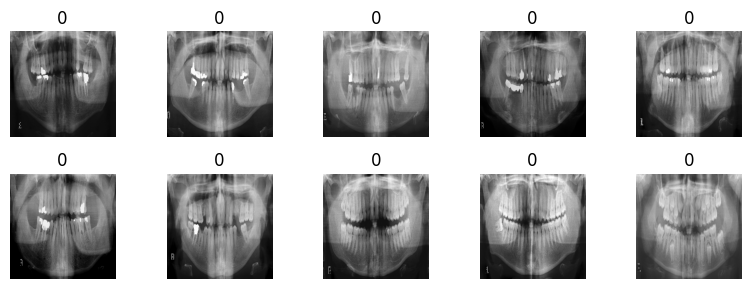

In [10]:
# visualizing 
n_samples = 10

indices = np.random.choice(len(X_test), n_samples, replace=False)
samples = X_test[indices]
labels = [y_test[i] for i in indices]

fig = plot_image_grid(samples, titles=labels)
plt.show()

[65 69 91 76 34 73 77 46 22 85]


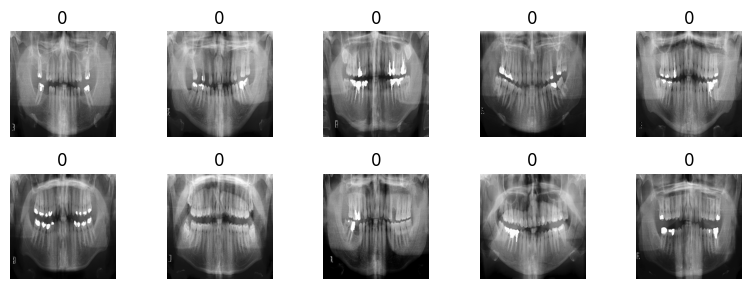

In [11]:
# visualizing 
n_samples = 10

indices = np.random.choice(len(X_train), n_samples, replace=False)
samples = X_train[indices]
labels = [y_train[i] for i in indices]
print(indices)
# print(samples)
fig = plot_image_grid(samples, titles=labels)
plt.show()

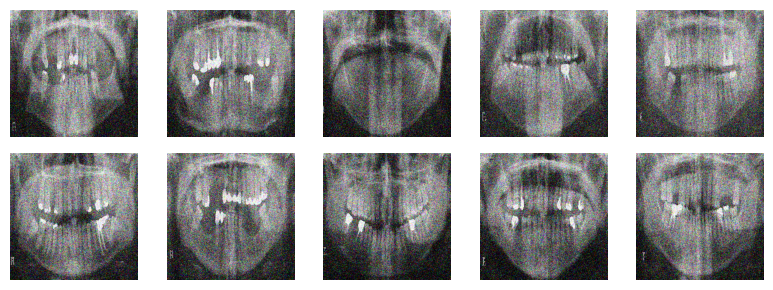

In [12]:
# adding Gaussian noise 

noise = np.random.normal(loc=0.0, scale=0.2 ,size= X_train.shape)
noisy_images = X_train + noise
X_train_noisy = np.clip(noisy_images, 0.0 , 1.0) # i dod cliping to normilze after adding noise 

plot_image_grid(X_train_noisy)
plt.show()


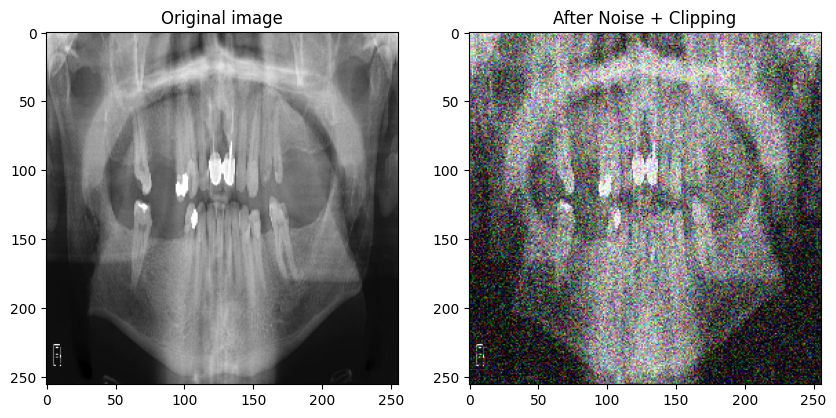

In [13]:
# Compare the first image
fig, axes = plt.subplots(1,2, figsize=(10, 5))


axes[0].set_title("Original image")
axes[0].imshow(X_train[0])


axes[1].set_title("After Noise + Clipping")
axes[1].imshow(X_train_noisy[0])

plt.show()

In [14]:
# Build and train an Autoencoder using convolutional (Encoder) 
# and transposed convolutional layers (Decoder) for dental X-ray denoising.

# making the  X_test data noisy

noise = np.random.normal(loc=0.0, scale=0.2 ,size= X_test.shape)
noisy_X_test_images = X_test + noise
x_test_noisy = np.clip(noisy_X_test_images, 0.0 , 1.0)


In [15]:
x_test_noisy.shape

(24, 256, 256, 3)

In [16]:
X_train_noisy.shape

(92, 256, 256, 3)

In [ ]:
def denoising_autoencoder(input_shape=(256, 256, 3), latent_dim=128):
    
    encoder_input = layers.Input(shape=input_shape)

    # --- ENCODER ---
    # Step 1: 256 -> 128
    conv1 = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_input)
    pool1 = layers.MaxPooling2D(2, padding='same')(conv1) # 128*128

    # Step 2: 128 -> 64
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(2, padding='same')(conv2) # 64*64

    # Step 3: 64 -> 32
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    pool3 = layers.MaxPooling2D(2, padding='same')(conv3) #32*32

    # --- BOTTLENECK ------
    x = layers.Flatten()(pool3)
    latent = layers.Dense(latent_dim, activation='relu', name='latent')(x)

    # --- DECODER ---
   
    x = layers.Dense(32 * 32 * 128, activation='relu')(latent)
    x = layers.Reshape((32, 32, 128))(x)
    
    # 1. Grow to 64x64. Now we can skip-connect with conv3 (which is also 64x64)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, conv3]) 

    # 2. Grow to 128x128. Now we can skip-connect with conv2 (which is also 128x128)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, conv2]) 

    # 3. Grow to 256x256. Now we can skip-connect with conv1 (which is also 256x256)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, conv1]) 

    # Final Output
    decoder_output = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    # Build model
    autoencoder = keras.Model(encoder_input, decoder_output)

    # Compile
    autoencoder.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return autoencoder

# The Flow Diagram
# how the data travels through that specific middle section:

# Encoder Output: (32, 32, 128) block.

# Flatten: Turns it into a line of 131,072 numbers.

# Dense (latent): Squeezes it into 256 numbers.

# Dense (expand): Expands it back to 131,072 numbers.

# Reshape: Turns the line back into a (32, 32, 128) block.

# Decoder Layers: Start growing the image back to 256x256.


# When data goes through the Dense/Bottleneck, it loses the "map" of where things are.
# It knows there is a "tooth," but it forgets exactly which pixel the edge of that tooth sits on.

# By using Concatenate([x, conv2]), you are giving the Decoder a "Cheat Sheet." * x provides the Cleanliness (it's learned how to remove noise).
# conv2 provides the Location (it has the original, sharp edges from the input).
# When they are glued together, the model can produce an image that is both clean AND sharp.

In [18]:
# calling the model function
model = denoising_autoencoder(latent_dim=128)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 131072)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent (Dense)      │ (None, 128)       │ 16,777,344 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 131072)    │ 16,908,288 │ latent[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 32,    │          0 │ dense[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    147,584 │ reshape[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │    147,520 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 256, 256,  │     36,896 │ concatenate_1[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      1,731 │ concatenate_2[0]

 Total params: 34,112,611 (130.13 MB)

 Trainable params: 34,112,611 (130.13 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# training the model
# Input: noisy images, Target: clean images
history = model.fit(
    X_train_noisy,
    X_train,        # clean target
    validation_data=(x_test_noisy, X_test),
    epochs=15,
    batch_size=32,
    shuffle=True,
    verbose=1
)

Epoch 1/15


2026-02-27 04:14:30.895975: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.
2026-02-27 04:14:58.222212: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


1/3 ━━━━━━━━━━━━━━━━━━━━ 10:51 326s/step - loss: 0.0540 - mae: 0.1844

2026-02-27 04:18:50.682090: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.
2026-02-27 04:19:15.743775: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


3/3 ━━━━━━━━━━━━━━━━━━━━ 669s 171s/step - loss: 0.0533 - mae: 0.1842 - val_loss: 0.0513 - val_mae: 0.1814
Epoch 2/15


2026-02-27 04:24:27.078738: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


3/3 ━━━━━━━━━━━━━━━━━━━━ 407s 106s/step - loss: 0.0505 - mae: 0.1804 - val_loss: 0.0484 - val_mae: 0.1780
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 518s 127s/step - loss: 0.0458 - mae: 0.1724 - val_loss: 0.0402 - val_mae: 0.1610
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 496s 141s/step - loss: 0.0353 - mae: 0.1494 - val_loss: 0.0235 - val_mae: 0.1195
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 739s 241s/step - loss: 0.0166 - mae: 0.0967 - val_loss: 0.0065 - val_mae: 0.0580
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 390s 105s/step - loss: 0.0072 - mae: 0.0646 - val_loss: 0.0091 - val_mae: 0.0750
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 210s 43s/step - loss: 0.0083 - mae: 0.0720 - val_loss: 0.0065 - val_mae: 0.0626
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 258s 52s/step - loss: 0.0058 - mae: 0.0579 - val_loss: 0.0042 - val_mae: 0.0461
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 147s 40s/step - loss: 0.0042 - mae: 0.0460 - val_loss: 0.0038 - val_mae: 0.0430
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 145s 45s/step - loss: 0.0037 - mae: 0.042

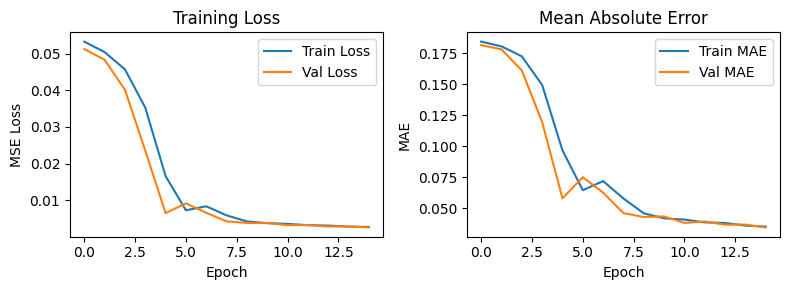

In [20]:
# PLOTING THE TRAINING HISTORY
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Loss
axes[0].set_title('Training Loss')
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()

# MAE
axes[1].set_title('Mean Absolute Error')
axes[1].plot(history.history['mae'], label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()

plt.tight_layout()
plt.show()

In [21]:
# EVALUATING THE DENOSING PERFORMANCE

# Denoise test images
x_test_denoised = model.predict(x_test_noisy, verbose=0)

# Calculate metrics
mse_noisy = np.mean((X_test - x_test_noisy) ** 2)
mse_denoised = np.mean((X_test - x_test_denoised) ** 2)

print('Performance Metrics:')
print('=' * 50)
print(f'\nNoisy Images vs Clean:')
print(f'  MSE:  {mse_noisy:.6f}')

print(f'\nDenoised Images vs Clean:')
print(f'  MSE:  {mse_denoised:.6f}')

print(f'\nImprovement:')
print(f'  MSE:  {(mse_noisy - mse_denoised) / mse_noisy * 100:.1f}% reduction')

Performance Metrics:

Noisy Images vs Clean:
  MSE:  0.034352

Denoised Images vs Clean:
  MSE:  0.002548

Improvement:
  MSE:  92.6% reduction


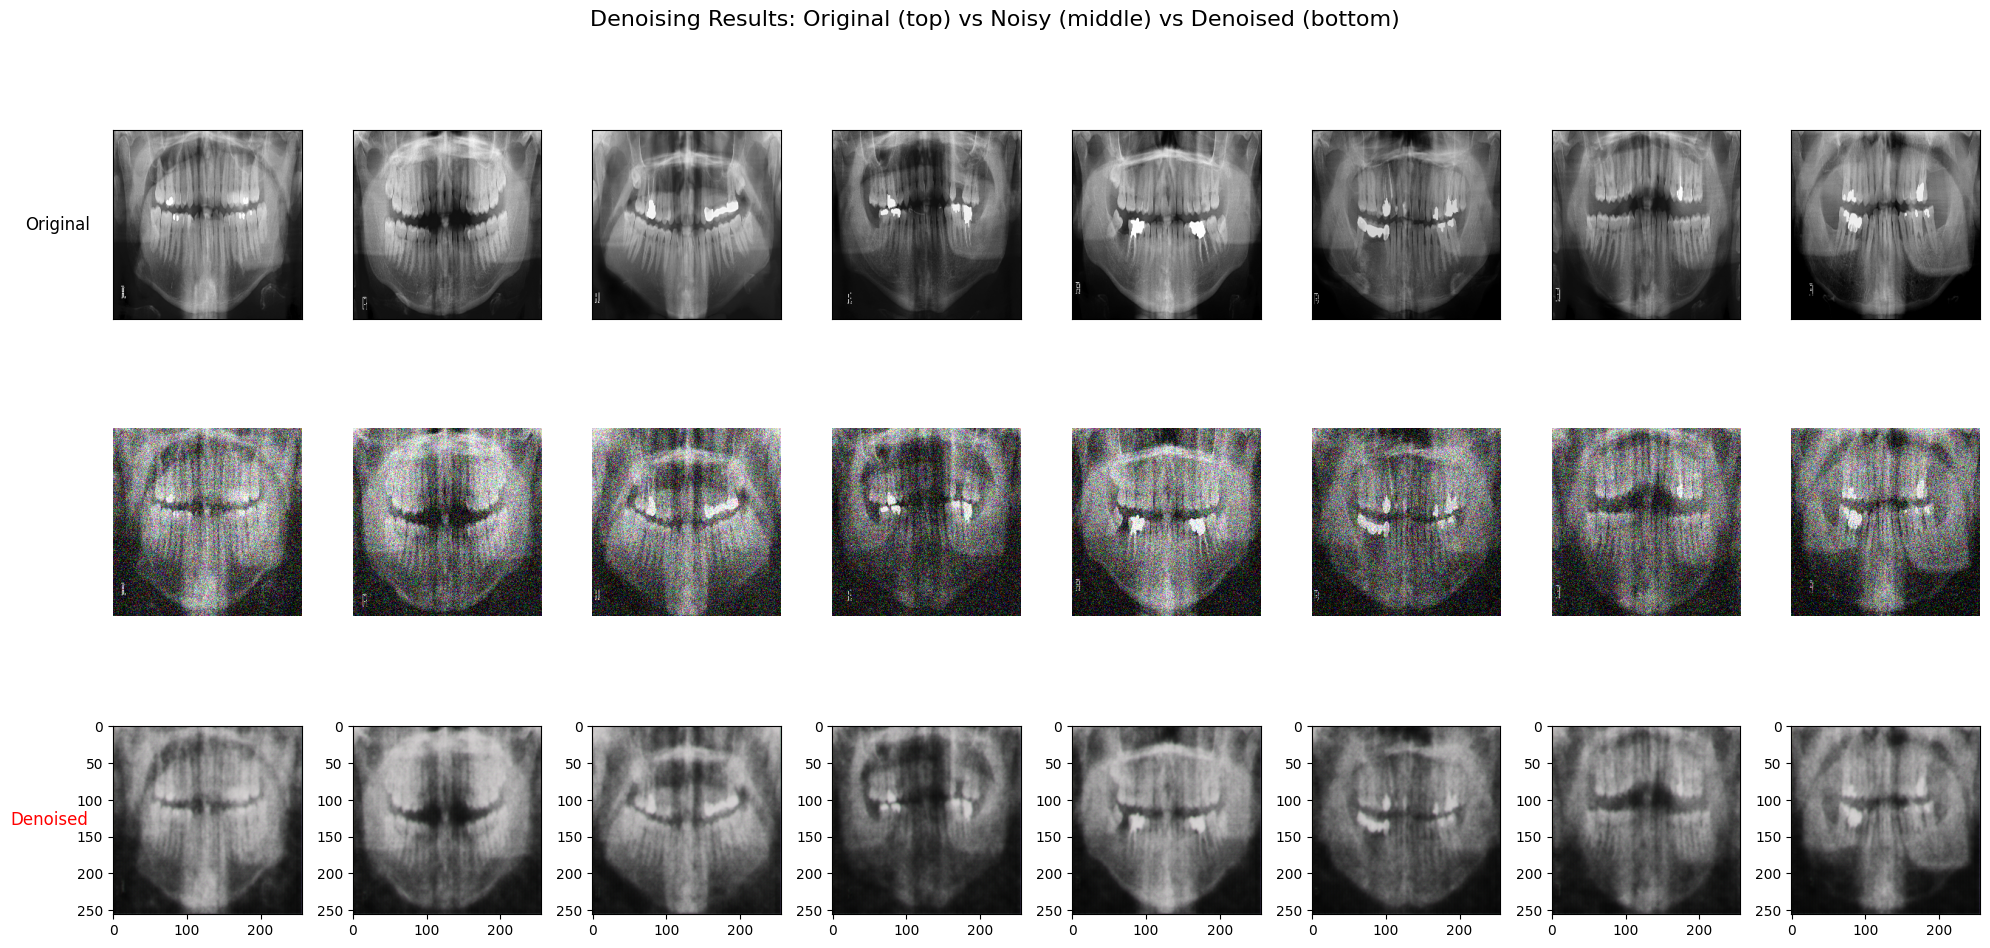

In [31]:
# Evaluate performance by visualizing test images 
# and reconstructed images to assess denoising quality. 

n_samples = 8
indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(3, n_samples, figsize=(20, 10))
fig.suptitle('Denoising Results: Original (top) vs Noisy (middle) vs Denoised (bottom)', 
             fontsize=16, y=0.995)

for i, idx in enumerate(indices):
    # Original clean image
    axes[0, i].imshow(X_test[idx])
    # axes[0, i].axis('off')
    # Instead of axis('off'), use this: becsaue axis('off') also showing x and y axis numbers that i will show for denoside images
    axes[0, i].set_xticks([]) # Hides top/bottom numbers
    axes[0, i].set_yticks([]) # Hides left/right numbers

    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12, rotation=0, labelpad=40, va='center')
    
    # Noisy image
    axes[1, i].imshow(x_test_noisy[idx])
    axes[1, i].axis('off')

    if i == 0:
        axes[1, i].set_ylabel('Noisy', fontsize=12, rotation=0, labelpad=40, va='center')
    
    # Denoised image
    axes[2, i].imshow(x_test_denoised[idx])
    # axes[2, i].axis('off')

    if i == 0:
        axes[2, i].set_ylabel('Denoised',color='red', fontsize=12, rotation=0, labelpad=20, va='center')
    
    # Add MSE metric for each image
    # mse_val = np.mean((X_test[idx:idx+1] - x_test_denoised[idx:idx+1]) ** 2)
    # axes[2, i].set_title(f'MSE: {mse_val:.4f}', fontsize=9)

plt.tight_layout()
plt.show()